In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
from skimage.transform import radon, iradon
from d2l.torch import Animator, Accumulator
import matplotlib_inline

In [2]:
class RadonDataset(data.Dataset):
    def __init__(self, dataset, num_angles):
        self.dataset = dataset
        self.num_angles = num_angles
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        image_np = image.squeeze().numpy()
        theta = np.linspace(0, 180, self.num_angles, endpoint=False)
        data = radon(image_np, theta)
        noisy_data =  data + np.random.normal(0, 1, data.shape) * np.mean(data) * 0.05
        noisy_data = torch.from_numpy(noisy_data).float().unsqueeze(0) 
        return noisy_data, image.float()

In [5]:
def load_data(batch_size, num_angles=30):
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    train_iter = torchvision.datasets.MNIST(root='../data', train=True, transform=trans, download=True)
    test_iter = torchvision.datasets.MNIST(root='../data', train=False, transform=trans, download=True)
    train_iter = RadonDataset(train_iter, num_angles)
    test_iter = RadonDataset(test_iter, num_angles)
    return (data.DataLoader(train_iter, batch_size, shuffle=True),
            data.DataLoader(test_iter, batch_size, shuffle=False))

In [6]:
batch_size = 24
num_angles = 30
train_iter, test_iter = load_data(batch_size, num_angles)

100.0%
100.0%
100.0%
100.0%


C:\Users\86188\anaconda3\envs\d2l-env\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


torch.Size([24, 1, 28, 30]) torch.Size([24, 1, 28, 28])


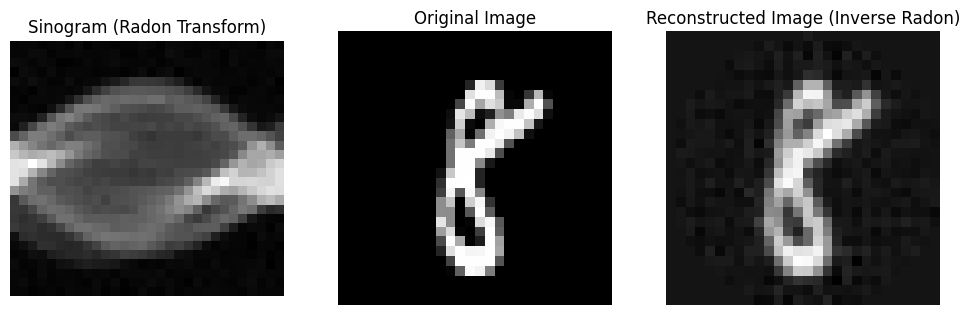

In [7]:
for i, (X, y) in enumerate(train_iter):
    print(X.shape, y.shape)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X[0, 0, ...], cmap='gray')  
    axes[0].set_title('Sinogram (Radon Transform)')
    axes[0].axis('off')
    axes[1].imshow(y[0, 0, ...], cmap='gray')  
    axes[1].set_title('Original Image')
    axes[1].axis('off')
    theta = np.linspace(0, 180, 30, endpoint=False)
    reconstructed_image = iradon(X[0, 0, ...].cpu().numpy(), theta=theta, filter_name='ramp')
    axes[2].imshow(reconstructed_image, cmap='gray')  
    axes[2].set_title('Reconstructed Image (Inverse Radon)')
    axes[2].axis('off')
    plt.show()
    break

In [8]:
class FCF(nn.Module):
    def __init__(self, num_detectors):
        super(FCF, self).__init__()
        self.num_detectors = num_detectors
        self.linear = nn.Linear(num_detectors, num_detectors)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = x.permute(0, 1, 3, 2)
        output = self.linear(x)
        return self.tanh(output)

In [9]:
# How the fully connected layer handles inputs
# net = FCF(28)
# y = net(X)

In [10]:
class SBP(nn.Module):
    def __init__(self, iradon_size, num_angles, learn=True, device='cpu'):
        super(SBP, self).__init__()
        self.iradon_size = iradon_size
        self.num_angles = num_angles
        self.learn = learn
        self.device = device
        if self.learn:
            self.gamma = nn.Parameter(torch.Tensor(iradon_size*iradon_size*num_angles).normal_())
        self.theta = torch.linspace(0, 180, num_angles) * torch.pi / 180
    def forward(self, x):
        _, channel, num_angles, num_detectors = x.shape
        x = x.reshape(-1, channel, num_detectors*num_angles)
        grid_x, grid_y = torch.meshgrid(torch.arange(-num_detectors//2, num_detectors//2), torch.arange(-num_detectors//2, num_detectors//2), indexing='ij')
        n_float = grid_x.unsqueeze(2)* torch.cos(self.theta).view(1, 1, -1) + grid_y.unsqueeze(2) * torch.sin(self.theta).view(1, 1, -1)
        n = torch.round(n_float).long() + num_detectors//2
        n = torch.clamp(n, 0, num_detectors - 1)
        # for i in range(num_angles):
        #     n[:, :, i] = n[:, :, i] + i * num_detectors
        n = n + num_detectors * torch.arange(0, num_angles)
        n = n.view(num_detectors*num_detectors*num_angles).to(self.device)
        output = torch.index_select(x, 2, n)
        if self.learn:
            output = output * self.gamma
        output = output.view(-1, channel, num_detectors*num_detectors, num_angles)
        output = torch.sum(output, 3)
        output = output.view(-1, channel, num_detectors, num_detectors)
        return output


In [11]:
# it degenerates into BP algorithm without learning
# net = SBP(28, num_angles, learn=False)
# y = net(X.permute(0, 1, 3, 2))
# plt.imshow(y[0, 0, ...].numpy())
# plt.show()

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, num_filters):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU()
        self.layer2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=True)
    def forward(self, x):
        output = self.relu(self.layer1(x))
        output = self.layer2(output)
        output += x
        return self.relu(output)

In [13]:
class rCNN(nn.Module):
    def __init__(self, num_filters):
        super(rCNN, self).__init__()
        model_list = [nn.Conv2d(1, num_filters, kernel_size=3, stride=1, padding=1, bias=True),
                      nn.GroupNorm(num_channels=num_filters, num_groups=1, affine=False), nn.ReLU()]
        model_list += [ResidualBlock(num_filters=num_filters), ResidualBlock(num_filters=num_filters), ResidualBlock(num_filters=num_filters)]
        model_list += [nn.Conv2d(num_filters, 1, kernel_size=3, stride=1, padding=1, bias=True)]
        self.model = nn.Sequential(*model_list)
    def forward(self, x):
        return self.model(x)
        

In [14]:
class iRadonMap(nn.Module):
    def __init__(self, num_detectors, num_angles, num_filters, device='cpu'):
        super(iRadonMap, self).__init__()
        self.num_detectors = num_detectors
        self.num_angles = num_angles
        self.num_filters = num_filters
        self.FCF = FCF(self.num_detectors)
        self.SBP = SBP(self.num_detectors, self.num_angles, device=device)
        self.rCNN = rCNN(self.num_filters)
    def forward(self, x):
        output = self.FCF(x)
        output = self.SBP(output)
        output = self.rCNN(output)
        return output


In [15]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    print("training on", device)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), betas=(0.9, 0.99), lr=lr, weight_decay=1e-6, eps=1e-5)
    animator = Animator(xlabel='epochs', xlim=[1, num_epochs], ylim=[0, 0.01], legend=['train loss', 'test_loss'])
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            train_l = metric[0] / metric[1]
            if i ==num_batches - 1 and (epoch + 1) % 1 == 0:
                animator.add(epoch + (i + 1) / num_batches, (train_l, None))
        if isinstance(net, nn.Module):
            net.eval()
        metric_1 = Accumulator(2)
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                metric_1.add(loss(net(X), y) * X.shape[0], X.shape[0])
        test_l = metric_1[0] / metric_1[1]
        if (epoch + 1) % 1 == 0:
            animator.add(epoch + 1, (None, test_l))
    print(f'train loss {train_l:.3f}, test loss {test_l:.3f} ')

In [16]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
def use_svg_display():
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

KeyboardInterrupt: 

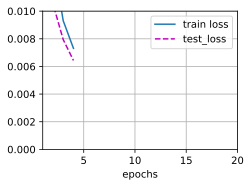

In [17]:
num_epochs, lr = 20, 0.001
net = iRadonMap(num_detectors=28, num_angles=30, num_filters=64, device=try_gpu())
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [ ]:
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to('cuda:0'), y.to('cuda:0')
        output = net(X)
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(output[0, 0, ...].cpu().detach().numpy(), cmap='gray')  
        axes[0].set_title('iRadon MAP')
        axes[0].axis('off')
        axes[1].imshow(y[0, 0, ...].cpu().detach().numpy(), cmap='gray')
        axes[1].set_title('Original Image')
        axes[1].axis('off')
        plt.show()
        break